# Setup


In [4]:
# === Imports ===
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as func
import scipy as sp
import scipy.sparse as sp
import networkx as nx
import pickle as pkl
from scipy.sparse.linalg import eigsh
import sys
from torch.optim import Adam
import matplotlib.pyplot as plt


# Utility Functions

In [5]:


def parse_index_file(filename):
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index


def sample_mask(idx, l):
    """Return a boolean mask of length l with True at positions in idx."""
    mask = np.zeros(l, dtype=np.bool_)   # np.bool is deprecated
    mask[idx] = True
    return mask


def scipy_coo_to_torch_sparse(coo: sp.coo_matrix, device=None, dtype=torch.float32):
    """Convert a SciPy COO matrix to a torch.sparse_coo_tensor (coalesced)."""
    coo = coo.tocoo()
    indices = np.vstack((coo.row, coo.col))
    i = torch.from_numpy(indices).long()
    v = torch.from_numpy(coo.data).to(dtype)
    shape = coo.shape
    t = torch.sparse_coo_tensor(i, v, torch.Size(shape))
    t = t.coalesce()
    return t.to(device) if device else t



def normalize_adj(adj):
    """Symmetric normalization:  D^{-1/2} A D^{-1/2}  (keeps SciPy COO)."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1)).flatten()
    d_inv_sqrt = np.power(rowsum, -0.5, where=rowsum > 0)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.0
    D_inv_sqrt = sp.diags(d_inv_sqrt)
    return (adj.dot(D_inv_sqrt).transpose().dot(D_inv_sqrt)).tocoo()


def preprocess_adj_to_torch(adj, add_self_loops=True, device=None, dtype=torch.float32):
    """A_hat = normalize(A + I); return torch sparse."""
    if add_self_loops:
        adj = adj + sp.eye(adj.shape[0], dtype=adj.dtype, format='coo')
    adj_norm = normalize_adj(adj)
    return scipy_coo_to_torch_sparse(adj_norm, device=device, dtype=dtype)


def preprocess_features_to_dense(features, device=None, dtype=torch.float32):
    """Row-normalize features (SciPy) and return dense torch.FloatTensor [N, F]."""
    rowsum = np.array(features.sum(1)).flatten()
    r_inv = np.power(rowsum, -1, where=rowsum != 0)
    r_inv[np.isinf(r_inv)] = 0.0
    R_inv = sp.diags(r_inv)
    feats_norm = R_inv.dot(features)          # still SciPy
    # For Cora/Citeseer/Pubmed sizes, dense is fine:
    feats_dense = torch.from_numpy(feats_norm.toarray()).to(dtype)
    return feats_dense.to(device) if device else feats_dense




def load_data_as_torch(dataset_str, device=None, dtype=torch.float32):
    """
    Load citation data (Cora/Citeseer/Pubmed) and return:
      adj_torch_sparse, features_dense, y_train, y_val, y_test, train_mask, val_mask, test_mask
    where labels (y_*) are torch.FloatTensor one-hot (for your masked loss) and masks are torch.BoolTensor.
    """
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for n in names:
        with open(f"data/ind.{dataset_str}.{n}", 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file(f"data/ind.{dataset_str}.test.index")
    test_idx_range = np.sort(test_idx_reorder)

    if dataset_str == 'citeseer':
        # Fix isolated nodes
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder) + 1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range - min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range - min(test_idx_range), :] = ty
        ty = ty_extended

    # Build feature matrix
    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]

    # Build adjacency from graph dict
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))  # SciPy sparse

    # Labels (one-hot)
    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    # Splits (standard GCN)
    idx_test = test_idx_range.tolist()
    idx_train = range(len(y))
    idx_val = range(len(y), len(y) + 500)

    train_mask_np = sample_mask(idx_train, labels.shape[0])
    val_mask_np = sample_mask(idx_val, labels.shape[0])
    test_mask_np = sample_mask(idx_test, labels.shape[0])

    y_train_np = np.zeros_like(labels)
    y_val_np = np.zeros_like(labels)
    y_test_np = np.zeros_like(labels)
    y_train_np[train_mask_np, :] = labels[train_mask_np, :]
    y_val_np[val_mask_np, :] = labels[val_mask_np, :]
    y_test_np[test_mask_np, :] = labels[test_mask_np, :]

    # ---- conversions to torch ----
    adj_torch = preprocess_adj_to_torch(adj, add_self_loops=True, device=device, dtype=dtype)
    features_torch = preprocess_features_to_dense(features, device=device, dtype=dtype)

    y_train = torch.from_numpy(y_train_np).to(dtype).to(device) if device else torch.from_numpy(y_train_np).to(dtype)
    y_val   = torch.from_numpy(y_val_np).to(dtype).to(device)   if device else torch.from_numpy(y_val_np).to(dtype)
    y_test  = torch.from_numpy(y_test_np).to(dtype).to(device)  if device else torch.from_numpy(y_test_np).to(dtype)

    train_mask = torch.from_numpy(train_mask_np).to(torch.bool).to(device) if device else torch.from_numpy(train_mask_np).to(torch.bool)
    val_mask   = torch.from_numpy(val_mask_np).to(torch.bool).to(device)   if device else torch.from_numpy(val_mask_np).to(torch.bool)
    test_mask  = torch.from_numpy(test_mask_np).to(torch.bool).to(device)  if device else torch.from_numpy(test_mask_np).to(torch.bool)

    return adj_torch, features_torch, y_train, y_val, y_test, train_mask, val_mask, test_mask


# Metrics

In [6]:
def masked_softmax_cross_entropy(preds, labels, mask):
    
    labels = labels.argmax(dim=1)
    loss = func.cross_entropy(preds, labels, reduction='none')

    mask = mask.float()
    mask /= mask.mean()
    loss *= mask

    return loss.mean()


def masked_accuracy(preds, labels, mask):
 

    pred_classes = torch.argmax(preds, dim=1)
    true_classes = torch.argmax(labels, dim=1)

    correct_prediction = (pred_classes == true_classes).float()

    # Convert mask to float and normalize it
    mask = mask.float()
    mask = mask / mask.mean()
    correct_prediction *= mask

    return correct_prediction.mean()

# Layers


In [7]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, bias = True):
        super(GraphConvolution,self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features,out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.xavier_uniform(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)
    
    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj,support) if adj.is_sparse else torch.mm(adj,support)
        if self.bias is not None:
            output += self.bias
        
        return output

class GCN(nn.Module):
    def __init__(self, in_features, hidden_dim, class_num, dropout, bias=True):
        super().__init__()
        self.gcn_1 = GraphConvolution(in_features, hidden_dim, bias)
        self.gcn_2 = GraphConvolution(hidden_dim, class_num, bias)  
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x, adj):
        x = func.relu(self.gcn_1(x, adj))
        x = self.dropout(x)
        x = self.gcn_2(x, adj)   # logits
        return x
    
    

# Training


In [12]:
def train_gcn(dataset='cora',
              hidden_dim=16,
              dropout=0.5,
              lr=0.01,
              weight_decay=5e-4,
              epochs=200,
              patience=10,
              seed=42):

    torch.manual_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Storing values for plots
    train_losses, val_losses, train_acc, val_acc = [], [], [], []

    # Load data (adj sparse torch, features dense torch, labels one-hot, masks bool)
    adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = \
        load_data_as_torch(dataset, device=device, dtype=torch.float32)
    
  

    num_nodes, in_features = features.shape
    num_classes = y_train.shape[1]

    model = GCN(in_features, hidden_dim, num_classes, dropout=dropout).to(device)

    
    optimizer = Adam([
    {'params': model.gcn_1.parameters(), 'weight_decay': 5e-4},  # regularized
    {'params': model.gcn_2.parameters(), 'weight_decay': 0.0}    # no regularization
    ], lr=lr)

    


    best_val = -float('inf')
    best_state = None
    wait = 0

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        logits = model(features, adj)  # [N, C]
        loss_train = masked_softmax_cross_entropy(logits, y_train, train_mask)
        acc_train = masked_accuracy(logits, y_train, train_mask)

        loss_train.backward()
        optimizer.step()

        # ---- validation ----
        model.eval()
        with torch.no_grad():
            logits = model(features, adj)
            loss_val = masked_softmax_cross_entropy(logits, y_val, val_mask)
            acc_val = masked_accuracy(logits, y_val, val_mask)

        # print(f"Epoch {epoch:03d} | "
            #   f"Train Loss {loss_train.item():.4f} Acc {acc_train.item():.4f} | "
            #   f"Val Loss {loss_val.item():.4f} Acc {acc_val.item():.4f}")

        # Early stopping on validation accuracy (or use -loss)
        score = acc_val.item()
        if score > best_val:
            best_val = score
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}. Best val acc: {best_val:.4f}")
                break

        # Appending data to lists
        train_losses.append(loss_train.item())
        val_losses.append(loss_val.item())
        train_acc.append(acc_train.item())
        val_acc.append(acc_val.item())

    
    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    with torch.no_grad():
        logits = model(features, adj)
        test_loss = masked_softmax_cross_entropy(logits, y_test, test_mask).item()
        test_acc = masked_accuracy(logits, y_test, test_mask).item()
    # print(f"Test  | Loss {test_loss:.4f} Acc {test_acc:.4f}")

    return model, {'val_acc': best_val, 'test_acc': test_acc, 
                   'train_losses': train_losses, 
                   'val_losses': val_losses, 
                   'train_acc': train_acc,
                   'val_acc': val_acc
                   }


C:\Users\zdixo\AppData\Local\Temp\ipykernel_8356\2649714054.py:71: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  objects.append(pkl.load(f, encoding='latin1'))
C:\Users\zdixo\AppData\Local\Temp\ipykernel_8356\2003895035.py:12: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(self.weight)


Early stopping at epoch 66. Best val acc: 0.7120

--- Model Performance ---
| Epoch | Train. Loss | Val. Loss   | Train. Acc. | Val. Acc. |
|-------|-------------|-------------|-------------|-----------|
| 1     | 1.7918      | 1.7896      | 0.1750      | 0.2060     |
| 2     | 1.7860      | 1.7866      | 0.3250      | 0.2480     |
| 3     | 1.7794      | 1.7840      | 0.3833      | 0.2840     |
| 4     | 1.7738      | 1.7816      | 0.3250      | 0.3920     |
| 5     | 1.7644      | 1.7792      | 0.5167      | 0.3820     |
| 6     | 1.7595      | 1.7763      | 0.6083      | 0.4440     |
| 7     | 1.7503      | 1.7732      | 0.6417      | 0.5360     |
| 8     | 1.7422      | 1.7700      | 0.6083      | 0.5580     |
| 9     | 1.7345      | 1.7669      | 0.6917      | 0.5380     |
| 10     | 1.7173      | 1.7639      | 0.7750      | 0.5340     |
| 11     | 1.7141      | 1.7607      | 0.7167      | 0.5520     |
| 12     | 1.7009      | 1.7571      | 0.6667      | 0.5740     |
| 13     | 1.

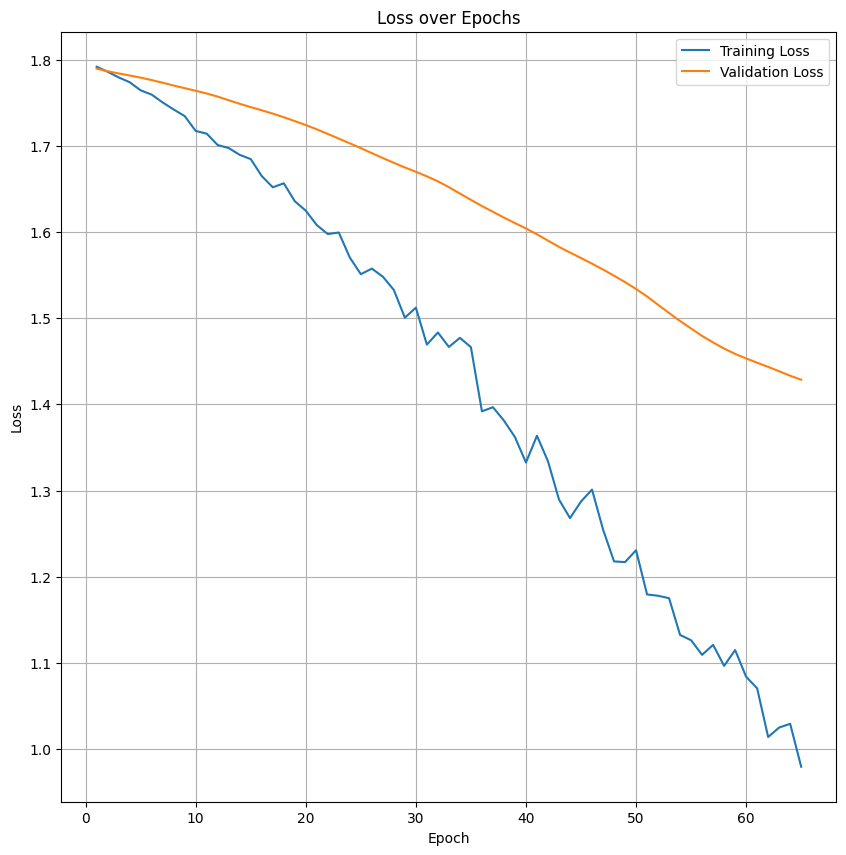

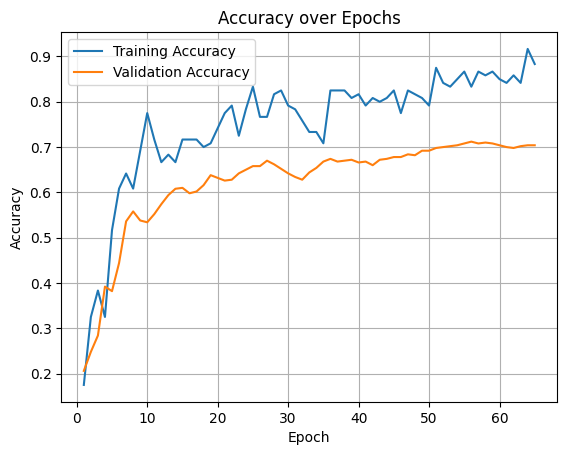

In [25]:
model, metrics = train_gcn(dataset='citeseer')

_train_losses = metrics['train_losses']
_val_losses = metrics['val_losses']
_train_acc = metrics['train_acc']
_val_acc = metrics['val_acc']



epochs = range(1, len(_train_losses) + 1)

print("\n--- Model Performance ---")
print(f"| Epoch | Train. Loss | Val. Loss   | Train. Acc. | Val. Acc. |")
print(f"|-------|-------------|-------------|-------------|-----------|")
for epoch, (train_loss, val_loss, train_acc, val_acc) in enumerate(zip(_train_losses, _val_losses, _train_acc, _val_acc), start=1):
    print(f"| {epoch}     | {train_loss:.4f}      | {val_loss:.4f}      | {train_acc:.4f}      | {val_acc:.4f}     |")

plt.figure(figsize=(10, 10))

plt.plot(epochs, _train_losses, label='Training Loss')
plt.plot(epochs, _val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

plt.show()

plt.plot(epochs, _train_acc, label='Training Accuracy')
plt.plot(epochs, _val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.show()

In [10]:
# Cora
model, m = train_gcn(dataset='cora')

C:\Users\zdixo\AppData\Local\Temp\ipykernel_8356\2649714054.py:71: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  objects.append(pkl.load(f, encoding='latin1'))
C:\Users\zdixo\AppData\Local\Temp\ipykernel_8356\2003895035.py:12: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(self.weight)


Epoch 001 | Train Loss 1.9460 Acc 0.1286 | Val Loss 1.9459 Acc 0.0740
Epoch 002 | Train Loss 1.9412 Acc 0.1643 | Val Loss 1.9431 Acc 0.1340
Epoch 003 | Train Loss 1.9351 Acc 0.2857 | Val Loss 1.9372 Acc 0.3760
Epoch 004 | Train Loss 1.9275 Acc 0.4929 | Val Loss 1.9309 Acc 0.5300
Epoch 005 | Train Loss 1.9172 Acc 0.5500 | Val Loss 1.9258 Acc 0.5420
Epoch 006 | Train Loss 1.9052 Acc 0.5929 | Val Loss 1.9213 Acc 0.5080
Epoch 007 | Train Loss 1.8962 Acc 0.5929 | Val Loss 1.9169 Acc 0.4880
Epoch 008 | Train Loss 1.8881 Acc 0.5929 | Val Loss 1.9125 Acc 0.5180
Epoch 009 | Train Loss 1.8809 Acc 0.5714 | Val Loss 1.9083 Acc 0.5500
Epoch 010 | Train Loss 1.8665 Acc 0.6500 | Val Loss 1.9044 Acc 0.5600
Epoch 011 | Train Loss 1.8624 Acc 0.6643 | Val Loss 1.9001 Acc 0.5360
Epoch 012 | Train Loss 1.8405 Acc 0.6714 | Val Loss 1.8941 Acc 0.5420
Epoch 013 | Train Loss 1.8329 Acc 0.7071 | Val Loss 1.8872 Acc 0.5660
Epoch 014 | Train Loss 1.8156 Acc 0.7071 | Val Loss 1.8788 Acc 0.5940
Epoch 015 | Train Lo

In [11]:
#Pubmed
model, m = train_gcn(dataset='pubmed')


C:\Users\zdixo\AppData\Local\Temp\ipykernel_8356\2649714054.py:71: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  objects.append(pkl.load(f, encoding='latin1'))
C:\Users\zdixo\AppData\Local\Temp\ipykernel_8356\2003895035.py:12: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(self.weight)


Epoch 001 | Train Loss 1.0963 Acc 0.4833 | Val Loss 1.0975 Acc 0.3300
Epoch 002 | Train Loss 1.0907 Acc 0.4000 | Val Loss 1.0947 Acc 0.4380
Epoch 003 | Train Loss 1.0864 Acc 0.6167 | Val Loss 1.0907 Acc 0.5980
Epoch 004 | Train Loss 1.0791 Acc 0.6500 | Val Loss 1.0846 Acc 0.6440
Epoch 005 | Train Loss 1.0698 Acc 0.7500 | Val Loss 1.0778 Acc 0.6220
Epoch 006 | Train Loss 1.0640 Acc 0.6500 | Val Loss 1.0711 Acc 0.6540
Epoch 007 | Train Loss 1.0568 Acc 0.7000 | Val Loss 1.0641 Acc 0.6480
Epoch 008 | Train Loss 1.0426 Acc 0.8000 | Val Loss 1.0577 Acc 0.6680
Epoch 009 | Train Loss 1.0337 Acc 0.8333 | Val Loss 1.0520 Acc 0.6800
Epoch 010 | Train Loss 1.0246 Acc 0.8167 | Val Loss 1.0473 Acc 0.6960
Epoch 011 | Train Loss 1.0162 Acc 0.8500 | Val Loss 1.0432 Acc 0.7080
Epoch 012 | Train Loss 1.0058 Acc 0.7500 | Val Loss 1.0383 Acc 0.7040
Epoch 013 | Train Loss 0.9991 Acc 0.8333 | Val Loss 1.0327 Acc 0.7040
Epoch 014 | Train Loss 0.9738 Acc 0.8167 | Val Loss 1.0263 Acc 0.6960
Epoch 015 | Train Lo